In [ ]:
# для принятия решения проанализирую:
# 1) является ли разница среднего дохода на пользователя между группами статистически значимой
# 2) если рассматривать платящих пользователей, есть ли статестически значимая разница в средних чеках между группами
# 3) есть ли разница конверсий из обычного пользователя в платящего между группами

In [1]:
import pandas as pd
import seaborn as sns
import scipy
from scipy.stats import chi2_contingency

In [2]:
inf = pd.read_csv('AB_test_inf.csv')

In [3]:
#подготовка данных
inf[['user_id', 'revenue', 'group']] = inf['user_id;revenue;testgroup'].str.split(';', expand=True)

In [4]:
inf.head()

,user_id;revenue;testgroup,user_id,revenue,group
0,1;0;b,1,0,b
1,2;0;a,2,0,a
2,3;0;a,3,0,a
3,4;0;b,4,0,b
4,5;0;b,5,0,b


In [5]:
inf.dtypes

user_id;revenue;testgroup    object
user_id                      object
revenue                      object
group                        object
dtype: object

In [6]:
# для расчета метрик revenue должно быть числом
inf["revenue"] = inf["revenue"].astype(float)

In [7]:
#проверка на нулевые значения и повторения id
print(inf.isnull().any().any())
print(inf['user_id'].duplicated().any())

False
False


In [8]:
group_a = inf.query("group == 'a'")
group_b = inf.query("group == 'b'")
paid_group_a = group_a.query("revenue > 0")
paid_group_b = group_b.query("revenue > 0")

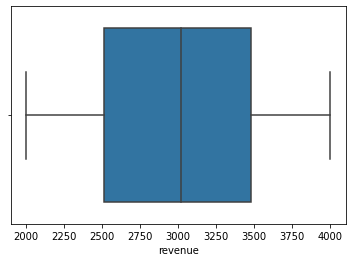

In [9]:
# построю боксплоты по оплатам (отдельно по контрольной и тестовой группе), чтобы в целом увидеть поведение платящих пользователей
sns.boxplot(data = paid_group_b, x = "revenue")

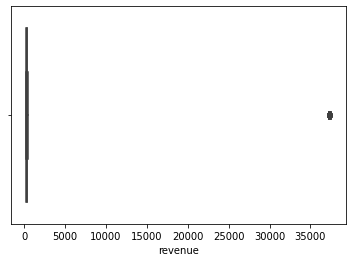

In [10]:
sns.boxplot(data = paid_group_a, x = "revenue")

In [11]:
# Сразу видно, что две группы очень отличаются. Оплаты тестовой группы распределены равномерно от 2000 до 4000,
#в контрольной группе подавляющее количество совершивших покупку принесли выручку не более 500, но есть очень большие выбросы
outliers_group_a = paid_group_a.query("revenue > 500")
print(outliers_group_a.shape)
#Но это не один выброс, а 123, при этом все id клиентов уникальны, а в тестовой группе такие крупные заказы отсутствуют
print(paid_group_a['revenue'].median())
print(paid_group_b['revenue'].median())
print(paid_group_b['revenue'].median() / paid_group_a['revenue'].median())

(123, 4)
311.0
3022.0
9.717041800643086


In [12]:
#!!! Сам эксперимент очень сомнителен. В группах разные, непересекающиеся сегменты пользователей по величине оплат,
# сплитование проведено некорректно. Необходимо пересобрать группы и запустить эксперимент повторно, но все же 
# закончу анализ имеющихся данных.

In [13]:
# в контрольной группе 0,06 процента пользователей (6,4 % от всех платящих в группе) приносят 89,4 % дохода
paid_group_a_big = paid_group_a.query('revenue > 600')
paid_group_a_small = paid_group_a.query('revenue < 600')
print(paid_group_a_big['revenue'].sum())
print(paid_group_a_small['revenue'].sum())
print(paid_group_a_big['revenue'].sum() / (paid_group_a_big['revenue'].sum() + paid_group_a_small['revenue'].sum()))
print(123 / 202103)
print(123 / 1928)

4590252.0
545937.0
0.8937077665950377
0.0006086005650584108
0.0637966804979253


In [14]:
#распределения не нормальны
print(scipy.stats.shapiro(group_a['revenue']))
print(scipy.stats.shapiro(group_b['revenue']))
print(scipy.stats.shapiro(paid_group_a['revenue']))
print(scipy.stats.shapiro(paid_group_b['revenue']))
print(group_a.shape)
print(paid_group_a.shape)
print(group_b.shape)
print(paid_group_b.shape)

ShapiroResult(statistic=0.008876502513885498, pvalue=0.0)
ShapiroResult(statistic=0.06588172912597656, pvalue=0.0)
ShapiroResult(statistic=0.2667924761772156, pvalue=0.0)
ShapiroResult(statistic=0.9583123922348022, pvalue=2.491345674771425e-22)
(202103, 4)
(1928, 4)
(202667, 4)
(1805, 4)


/opt/tljh/user/lib/python3.7/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [15]:
#данные в group_a['revenue'] и group_b['revenue'] распределены не нормально, сравню с помощью критерия Манна-Уитни
#нулевая гипотеза - в этих двух группах нет различий в распределении частот
#альтернативная гипотеза - есть различия
print(scipy.stats.mannwhitneyu(group_a['revenue'], group_b['revenue']))
# не могу отклонить нулевую гипотезу
# так как выборки достаточно крупные, можно сравнить их с помощью т-теста
#нулевая гипотеза - статистически значимого различия между средними нет
#альтернативная гипотеза - статистически значимые различия между средними есть
print(scipy.stats.ttest_ind(group_a['revenue'], group_b['revenue']))
# т-тест тоже не позволяет отклонить нулевую гипотезу

MannwhitneyuResult(statistic=20491259376.0, pvalue=0.06269701316074398)
Ttest_indResult(statistic=-0.6242026493616787, pvalue=0.532494858971837)


In [16]:
# теперь таким же способом с такими же гипотезами сравню средний чек на одного ПЛАТЯЩЕГО пользователя
print(scipy.stats.mannwhitneyu(paid_group_a['revenue'], paid_group_b['revenue']))
print(scipy.stats.ttest_ind(paid_group_a['revenue'], paid_group_b['revenue']))
# статистически значимых различий между средними нет, в распределении частот разница есть, это было видно и на графиках:
# в тестовой группе они распределены равномерно, в контрольной - много маленьких чеков и чуть больше сотни очень больших

MannwhitneyuResult(statistic=222015.0, pvalue=0.0)
Ttest_indResult(statistic=-1.5917100176862002, pvalue=0.11153459157259504)


In [17]:
# проверю есть ли статистически значимая разница между конверсией из обычного пользователя в платящего
# так как это конверсия, сравниваемы данные примерно одинаковые, наблюдения не зависимы, буду использовать критерий хи квадрат
# нулевая гипотеза: распределение конверсии в покупку в группе a соответствует распределению конверсии в покупку в группе b
# альтернативная гипотеза: не соответствует
conversion_to_purchase = pd.DataFrame({'all_in_group': [202667, 202103], 'paid in group': [1805, 1928]})
chi2_contingency(conversion_to_purchase)
# хи значение статистики 4.294148751290091, при степени свободы 1 хи значение из таблицы = 3.84 
# получившеeся хи значение больше, pvalue < 0.05 значит, можно отвергнуть нулевую гипотезу
# НО, хи значение статистики не намного выше табличного, а pvalue не намного меньше 0.05, поэтому утвержать, что в тестовой
# группе конверсия закономерно ниже (0,89% против 0,95) нужно с большой осторожностью.

(4.294148751290091,
 0.03824373651044168,
 1,
 array([[202603.48501725,   1868.51498275],
        [202166.51498275,   1864.48501725]]))

In [18]:
# Итог анализа имеющихся данных:
# Разница в ARPU в двух группах статистически не значима, разница среднего дохода от платящих пользователей тоже
# конверсия в покупку в контрольной группе выше на 0,06 процента, с большой долей вероятости это закономерно, но утверждать точно нельзя
# тестовая группа более стабильна, ее медианное значение в 9,72 раза выше, чем у контрольной и в ней нет выбросов
# в контрольной группе важную роль играют 123 'кита', которые 89,4% дохода от всей контрольной группы

In [19]:
# ИТОГ:
# A/B тест проведен некорректно. Необходимо пересобрать группы и запустить эксперимент повторно
# Рекомендации на случай, если возможности провести тест повторно нет:
# ни один из наборов акционных предложений не является очевидно лучшим,
# ститистически значимых различий между ними почти нет (у контрольной группы немного больше конверсия в покупку),
# я бы рекомендовал либо придерживаться того варианта, который был показан группе b (выше описывал, что он более надежный, 
# при варианте a уход небольшого количества игроков приведет к серьезным потерям), либо отдельно проанализировать этих 123 'китов'
# из контрольной группы, собрав дополнительные данные (это вполне реально, их мало), чтобы ответить на вопросы:
# чем они отличаются от среднего потребителя?; почему таких нет в тестовой группе?; можно ли что-то сделать, чтобы их было
# больше и тд.